In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import logging
import os
import warnings

import torch
from torch.utils.data import Dataset, DataLoader

os.chdir("/home/qian.hu/neuron_process_waveform/npf_GWwaveform")

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.disable(logging.ERROR)

N_THREADS = 10
IS_FORCE_CPU = False  # Nota Bene : notebooks don't deallocate GPU memory

if IS_FORCE_CPU:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""

torch.set_num_threads(N_THREADS)
import h5py
#10:2:1=train:test:valid

import scipy
import matplotlib.pyplot as plt
import numpy as np
from utils import visualize_1d
from utils.ntbks_helpers import get_all_gp_datasets
from npf.utils.helpers import rescale_range

from gw.utils import gwutils

import bilby


In [2]:
torch.cuda.is_available()

True

In [2]:
root_dir = '/home/qian.hu/neuron_process_waveform/npf_GWwaveform/data/'
h5filename = root_dir + 'gw_fd_8D_q7a5_2N2000_Pv2v4P_downsampled.h5'

Ngw = gwutils.get_gwfdh5_nsample(h5filename)

Ntrain = int(Ngw*0.7)
Ntest = int(Ngw*0.15)
Nvalid = Ngw - Ntrain - Ntest

random_index = np.random.permutation(Ngw)
train_index = random_index[:Ntrain]
test_index = random_index[Ntrain:Ntrain+Ntest]
valid_index = random_index[-Nvalid:]

gw_dataset = gwutils.GWDatasetFDMultimodelNDOutput(h5file=h5filename, indcies=train_index)
gw_test_dataset = gwutils.GWDatasetFDMultimodelNDOutput(h5file=h5filename, indcies=test_index)
gw_valid_dataset = gwutils.GWDatasetFDMultimodelNDOutput(h5file=h5filename, indcies=valid_index)


In [9]:
gw_dataset[0][1]

tensor([[[ 0.0000e+00],
         [ 0.0000e+00]],

        [[ 2.4146e-04],
         [-7.7869e-04]],

        [[-5.3169e-05],
         [ 1.0136e-03]],

        ...,

        [[ 8.2283e-01],
         [-3.2957e-01]],

        [[ 8.1892e-01],
         [-3.2871e-01]],

        [[ 1.2248e+00],
         [-6.7866e-01]]])

In [3]:
gw_dataset.n_samples

700

In [26]:
train_label = 'IMRPv2EOBv4P_q7a5fd_2N2000_2Doutput'

gw_datasets = {}
gw_test_datasets = {}
gw_valid_datasets = {}

gw_datasets[train_label] = gw_dataset
gw_test_datasets[train_label] = gw_test_dataset
gw_valid_datasets[train_label] = gw_valid_dataset

In [27]:
from utils.ntbks_helpers import get_all_gp_datasets, get_img_datasets

from npf.utils.datasplit import (
    CntxtTrgtGetter,
    GetRandomIndcs,
    GridCntxtTrgtGetter,
    RandomMasker,
    get_all_indcs, ##
    no_masker,
)
from utils.data import cntxt_trgt_collate, get_test_upscale_factor

# CONTEXT TARGET SPLIT
get_cntxt_trgt_1d = cntxt_trgt_collate(
    CntxtTrgtGetter(
        contexts_getter=GetRandomIndcs(a=0.3, b=0.5), targets_getter=GetRandomIndcs(a=0.3, b=0.5), #GetRandomIndcs(a=0.8, b=0.9)
    )
)

In [28]:
from functools import partial

from npf import ConvCNP, GridConvCNP
from npf.architectures import CNN, MLP, ResConvBlock, SetConv, discard_ith_arg
from npf.utils.helpers import CircularPad2d, make_abs_conv, make_padded_conv
from utils.helpers import count_parameters

R_DIM = 128
KWARGS = dict(
    r_dim=R_DIM,
    Decoder=discard_ith_arg(  # disregards the target features to be translation equivariant
        partial(MLP, n_hidden_layers=4, hidden_size=R_DIM), i=0
    ),
)


CNN_KWARGS = dict(
    ConvBlock=ResConvBlock,
    is_chan_last=True,  # all computations are done with channel last in our code
    n_conv_layers=2,  # layers per block
)


# off the grid
model_1d = partial(
    ConvCNP,
    x_dim=1,
    y_dim=2,
    Interpolator=SetConv,
    CNN=partial(
        CNN,
        Conv=torch.nn.Conv1d,
        Normalization=torch.nn.BatchNorm1d,
        n_blocks=5,
        kernel_size=19,
        **CNN_KWARGS,
    ),
    density_induced=64,  # density of discretization
    **KWARGS,
)

n_params_1d = count_parameters(model_1d())
print(f"Number Parameters (1D): {n_params_1d:,d}")

Number Parameters (1D): 276,998


In [31]:
import skorch
from npf import CNPFLoss
from utils.ntbks_helpers import add_y_dim
from utils.train import train_models

KWARGS = dict(
    is_retrain=True,  # whether to load precomputed model or retrain
    is_continue_train=True,
    criterion=CNPFLoss,
    chckpnt_dirname="/home/qian.hu/neuron_process_waveform/npf_GWwaveform/gw/trained_models/",
    device="cuda",
    lr=1e-6,
    decay_lr=10,
    seed=123,
    batch_size=2,
)

# 1D
trainers_1d = train_models(
    gw_datasets,
    {"ConvCNP": model_1d},
    test_datasets=gw_test_datasets,
    iterator_train__collate_fn=get_cntxt_trgt_1d,
    iterator_valid__collate_fn=get_cntxt_trgt_1d,
    max_epochs=10,
    **KWARGS
)




--- Training IMRPv2EOBv4P_q7a5fd_2N2000_2Doutput/ConvCNP/run_0 ---



  epoch    train_loss    valid_loss    cp      dur
-------  ------------  ------------  ----  -------
     46    13542.8406    12729.4479     +  36.1287


     47    13932.0017    13116.1498        35.9948


     48    13721.6607    12686.1130     +  40.6977


     49    13643.2056    13126.5110        33.5923


     50    13474.2985    12870.0680        32.8372


     51    13612.9286    12230.9938     +  42.0524


     52    13582.7239    13083.4260        35.7959


     53    13980.4472    13451.1468        38.3403


     54    13559.7106    12451.5229        38.5688


     55    13667.3901    13049.5286        33.1126


IMRPv2EOBv4P_q7a5fd_2N2000_2Doutput/ConvCNP/run_0 | best epoch: 51 | train loss: 13474.2985 | valid loss: 12230.9938 | test log likelihood: -15135.04


In [32]:
model_pv2v4p = trainers_1d[f'{train_label}/ConvCNP/run_0'].module_

testset = gw_test_datasets[f'{train_label}']

In [33]:
gw_test_dataset.waveform_models

array(['IMRPhenomPv2', 'SEOBNRv4P'], dtype='<U12')

In [35]:
#look_approx = 'IMRPhenomPv2'
def get_specific_model(ds,index, approx, rescalex=True):
    f = ds.frequency_array
    h1 = ds.fdwaveforms_all[approx]['plus']['real'][index] 
    h2 = ds.fdwaveforms_all[approx]['cross']['imag'][index]
    h1 = h1 / 100
    h2 = h2 / 100
    h = np.array([h1, h2]).T

    if rescalex:
        f = rescale_range(f, (f.min(),f.max()), (-1,1))

    return torch.from_numpy(f).unsqueeze(-1).type(torch.float32), torch.from_numpy(h).type(torch.float32)

look_index = 2

chirp_mass_look = gw_test_dataset.source_parameters['chirp_mass'][look_index]

#x_test_imr, y_test_imr = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2')
#x_test_eob, y_test_eob = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P')

x_test_imr, y_test_imr = get_specific_model(gw_test_dataset, look_index, 'IMRPhenomPv2')
x_test_eob, y_test_eob = get_specific_model(gw_test_dataset, look_index, 'SEOBNRv4P')

len_data = len(x_test_imr)
len_context = int(len_data*1)
context_index = np.sort( np.random.permutation(len_data)[:len_context] )
target_index = np.arange(len_data)

x_test_context_imr = x_test_imr[context_index]
y_test_context_imr = y_test_imr[context_index]

x_test_context_eob = x_test_eob[context_index]
y_test_context_eob = y_test_eob[context_index]

x_test_target_imr = x_test_imr[target_index]
x_yest_target_imr = y_test_imr[target_index]
x_test_target_eob = x_test_eob[target_index]
x_yest_target_eob = y_test_eob[target_index]




In [36]:
#x_test_target_imr_unsc, y_test_target_imr_unsc = gw_test_dataset.get_specific_model(look_index, 'IMRPhenomPv2', rescalex=False)
x_test_target_imr_unsc, y_test_target_imr_unsc = get_specific_model(gw_test_dataset, look_index, 'IMRPhenomPv2', rescalex=False)
x_test_target_imr_unsc = x_test_target_imr_unsc.squeeze().numpy()
y_test_target_imr_unsc = y_test_target_imr_unsc.squeeze().numpy()

#x_test_target_eob_unsc, y_test_target_eob_unsc = gw_test_dataset.get_specific_model(look_index, 'SEOBNRv4P', rescalex=False)
x_test_target_eob_unsc, y_test_target_eob_unsc = get_specific_model(gw_test_dataset, look_index, 'SEOBNRv4P', rescalex=False)
x_test_target_eob_unsc = x_test_target_eob_unsc.squeeze().numpy()
y_test_target_eob_unsc = y_test_target_eob_unsc.squeeze().numpy()

In [37]:
nsample = 1
mean_imr, std_imr = gwutils.get_predictions(model_pv2v4p, x_test_context_imr.unsqueeze(0), y_test_context_imr.unsqueeze(0),
                                    x_test_target_imr.unsqueeze(0), nsample)
mean_eob, std_eob = gwutils.get_predictions(model_pv2v4p, x_test_context_eob.unsqueeze(0), y_test_context_eob.unsqueeze(0),
                                    x_test_target_eob.unsqueeze(0), nsample)

In [16]:
real_freq_test_imr, real_amp_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [y_test_target_imr_unsc], chirp_mass_look)
real_freq_test_imr, real_mean_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [mean_imr], chirp_mass_look)
real_freq_test_imr, real_std_test_imr = gwutils.unscale_scaled_fdwaveforms(x_test_target_imr_unsc, [std_imr], chirp_mass_look)


real_freq_test_eob, real_amp_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [y_test_target_eob_unsc], chirp_mass_look)
real_freq_test_eob, real_mean_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [mean_eob], chirp_mass_look)
real_freq_test_eob, real_std_test_eob = gwutils.unscale_scaled_fdwaveforms(x_test_target_eob_unsc, [std_eob], chirp_mass_look)

real_amp_test_imr = real_amp_test_imr[0]
real_mean_test_imr = real_mean_test_imr[0]
real_std_test_imr = real_std_test_imr[0]
real_amp_test_eob = real_amp_test_eob[0]
real_mean_test_eob = real_mean_test_eob[0]
real_std_test_eob = real_std_test_eob[0]


ValueError: operands could not be broadcast together with shapes (13043,2) (13043,) 

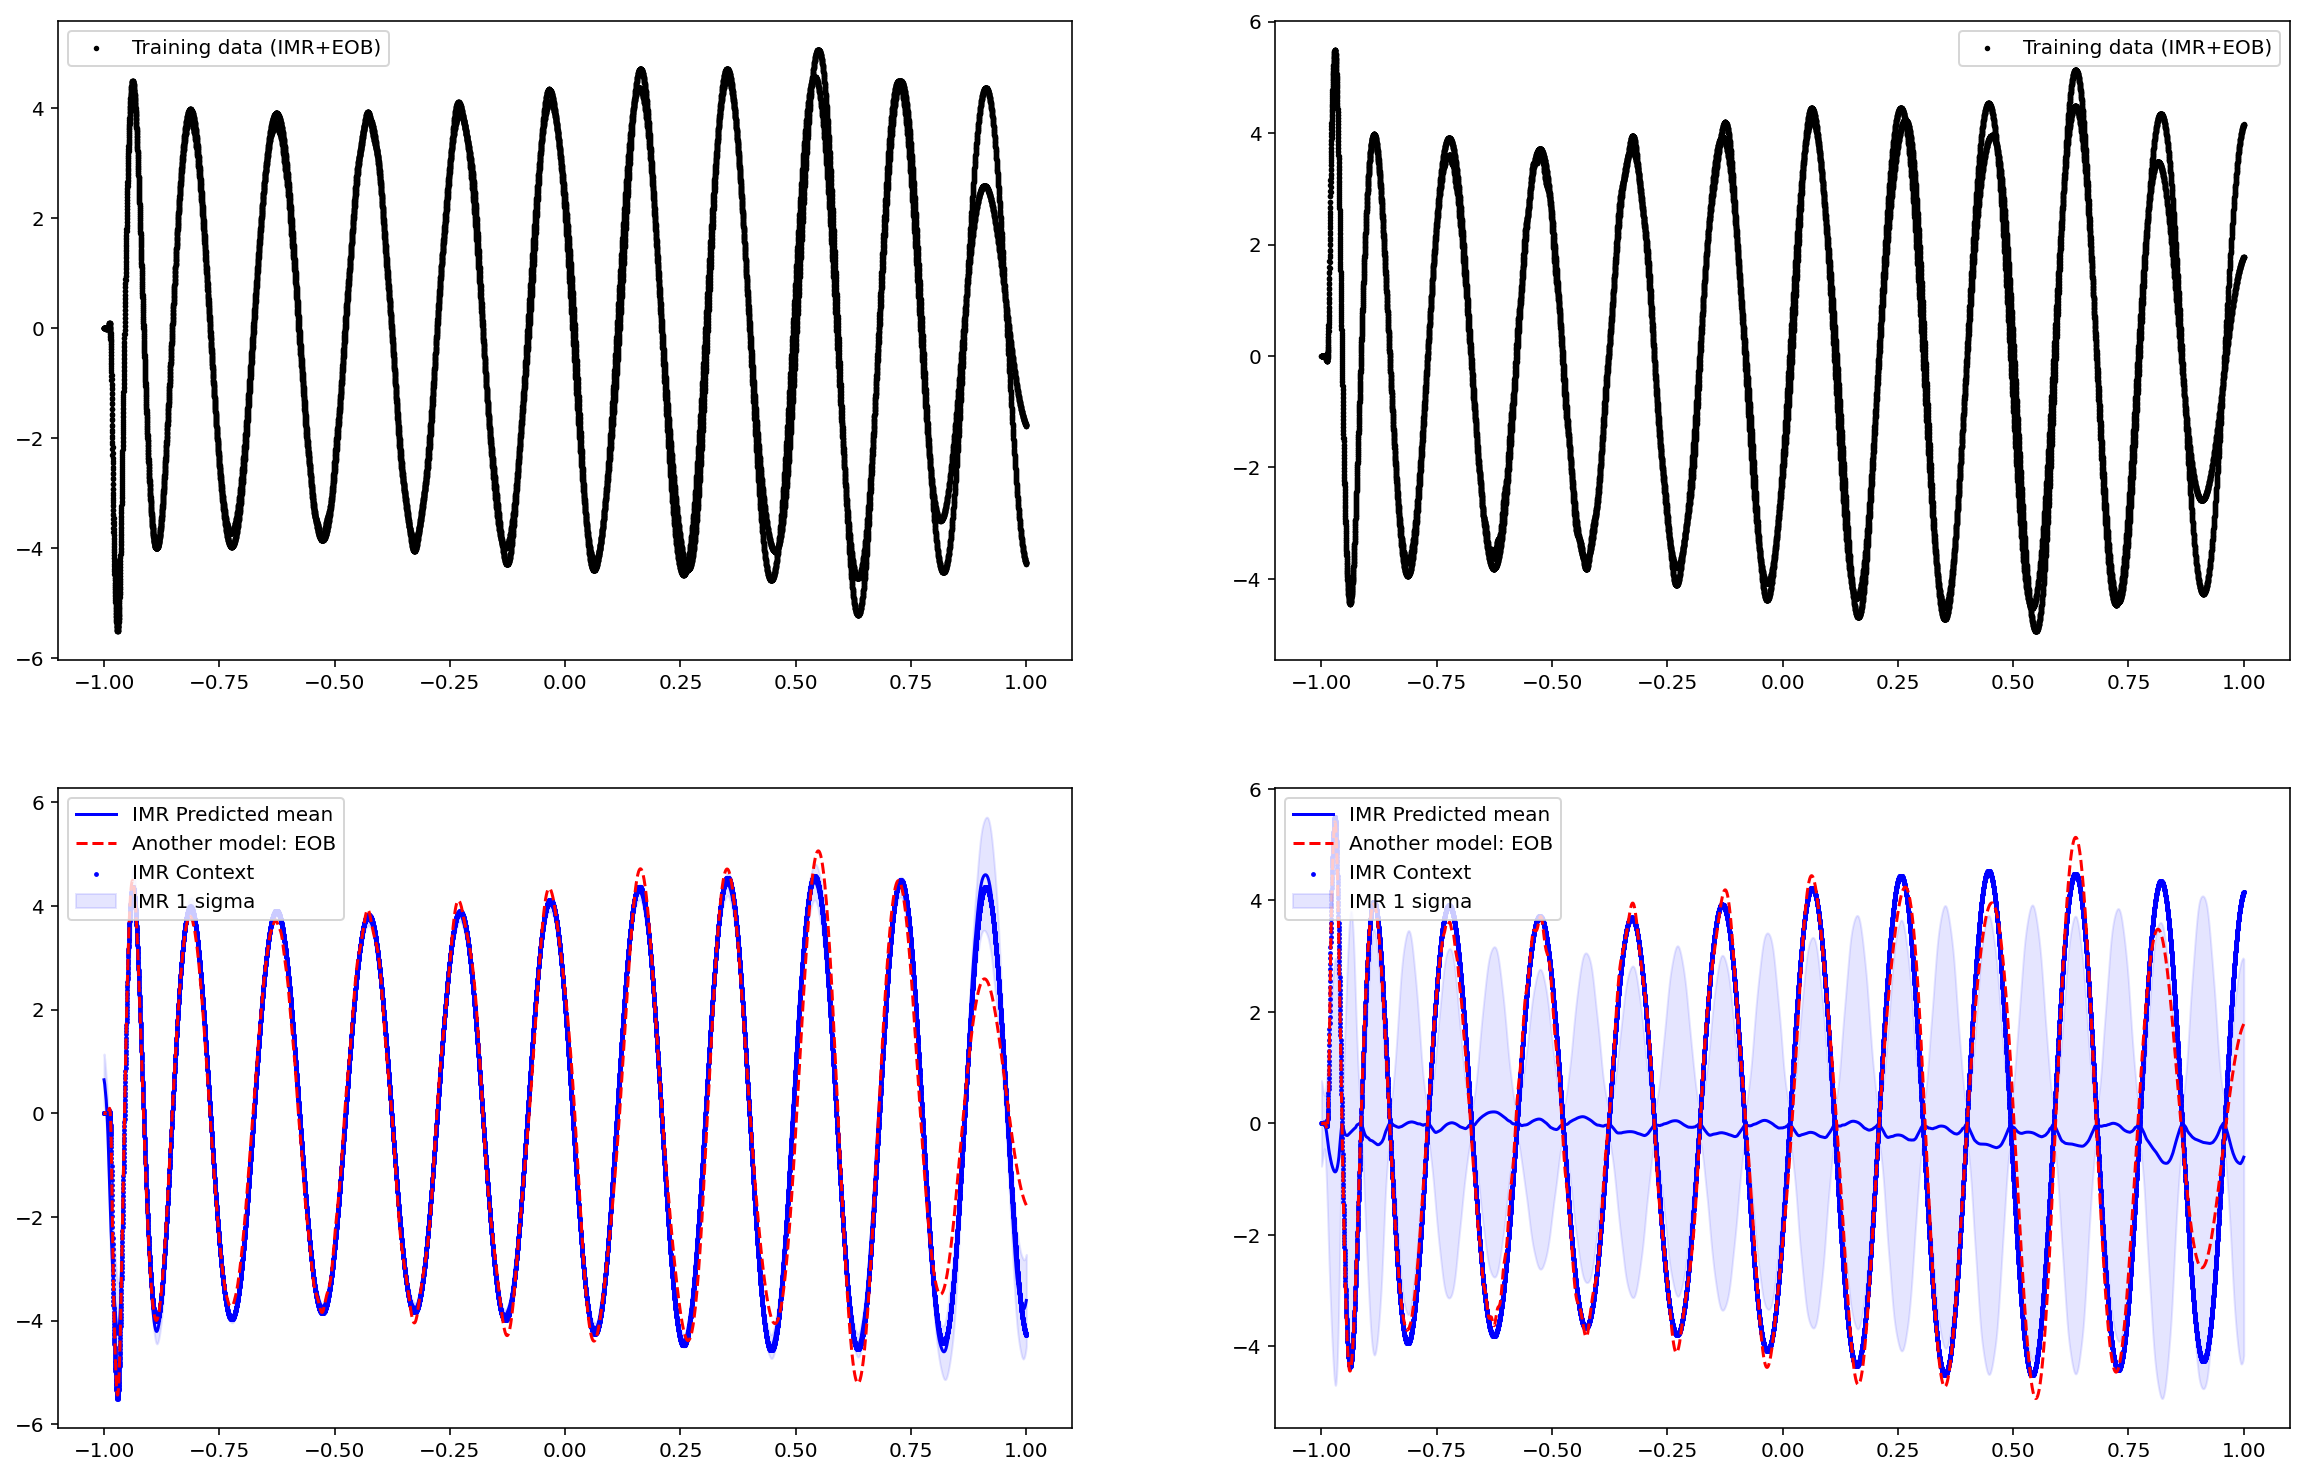

In [38]:
plt.figure(figsize=(20,20))
plt.subplot(3,2,1)
plt.scatter(gw_test_dataset[look_index][0], gw_test_dataset[look_index][1][:,0], label='Training data (IMR+EOB)', color='k',s=3)
plt.legend()
plt.subplot(3,2,2)
plt.scatter(gw_test_dataset[look_index][0], gw_test_dataset[look_index][1][:,1], label='Training data (IMR+EOB)', color='k',s=3)
plt.legend()


plt.subplot(3,2,3)
plt.scatter(x_test_context_imr, y_test_context_imr[:,0], label='IMR Context', color='b',s=2)
plt.plot(x_test_target_imr, mean_imr[:,0], label='IMR Predicted mean', color='b',linestyle='-')
plt.fill_between(x=x_test_target_imr.squeeze(), y1=mean_imr[:,0]-std_imr[:,0], y2=mean_imr[:,0]+std_imr[:,0], label='IMR 1 sigma', alpha=0.1, color='b')
plt.plot(x_test_eob, y_test_eob[:,0], label='Another model: EOB', color='r',linestyle='--')
plt.legend()
#plt.xlim(-0.,0.7)

plt.subplot(3,2,4)
plt.scatter(x_test_context_imr, y_test_context_imr[:,1], label='IMR Context', color='b',s=2)
plt.plot(x_test_target_imr, mean_imr[:,1], label='IMR Predicted mean', color='b',linestyle='-')
plt.fill_between(x=x_test_target_imr.squeeze(), y1=mean_imr[:,1]-std_imr[:,1], y2=mean_imr[:,1]+std_imr[:,1], label='IMR 1 sigma', alpha=0.1, color='b')
plt.plot(x_test_eob, y_test_eob[:,1], label='Another model: EOB', color='r',linestyle='--')
plt.legend()
#plt.xlim(-0.,0.7)


'''
plt.subplot(3,2,5)
plt.scatter(x_test_context_eob, y_test_context_eob, label='EOB Context', color='r',s=2)
plt.plot(x_test_target_eob, mean_eob, label='EOB Predicted mean', color='r',linestyle='-')
plt.fill_between(x=x_test_target_eob.squeeze(), y1=mean_eob-std_eob, y2=mean_eob+std_eob, label='EOB 1 sigma', alpha=0.1, color='r')
plt.plot(x_test_imr, y_test_imr, label='Another model: IMR', color='b',linestyle='--')
plt.legend()
'''
#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()

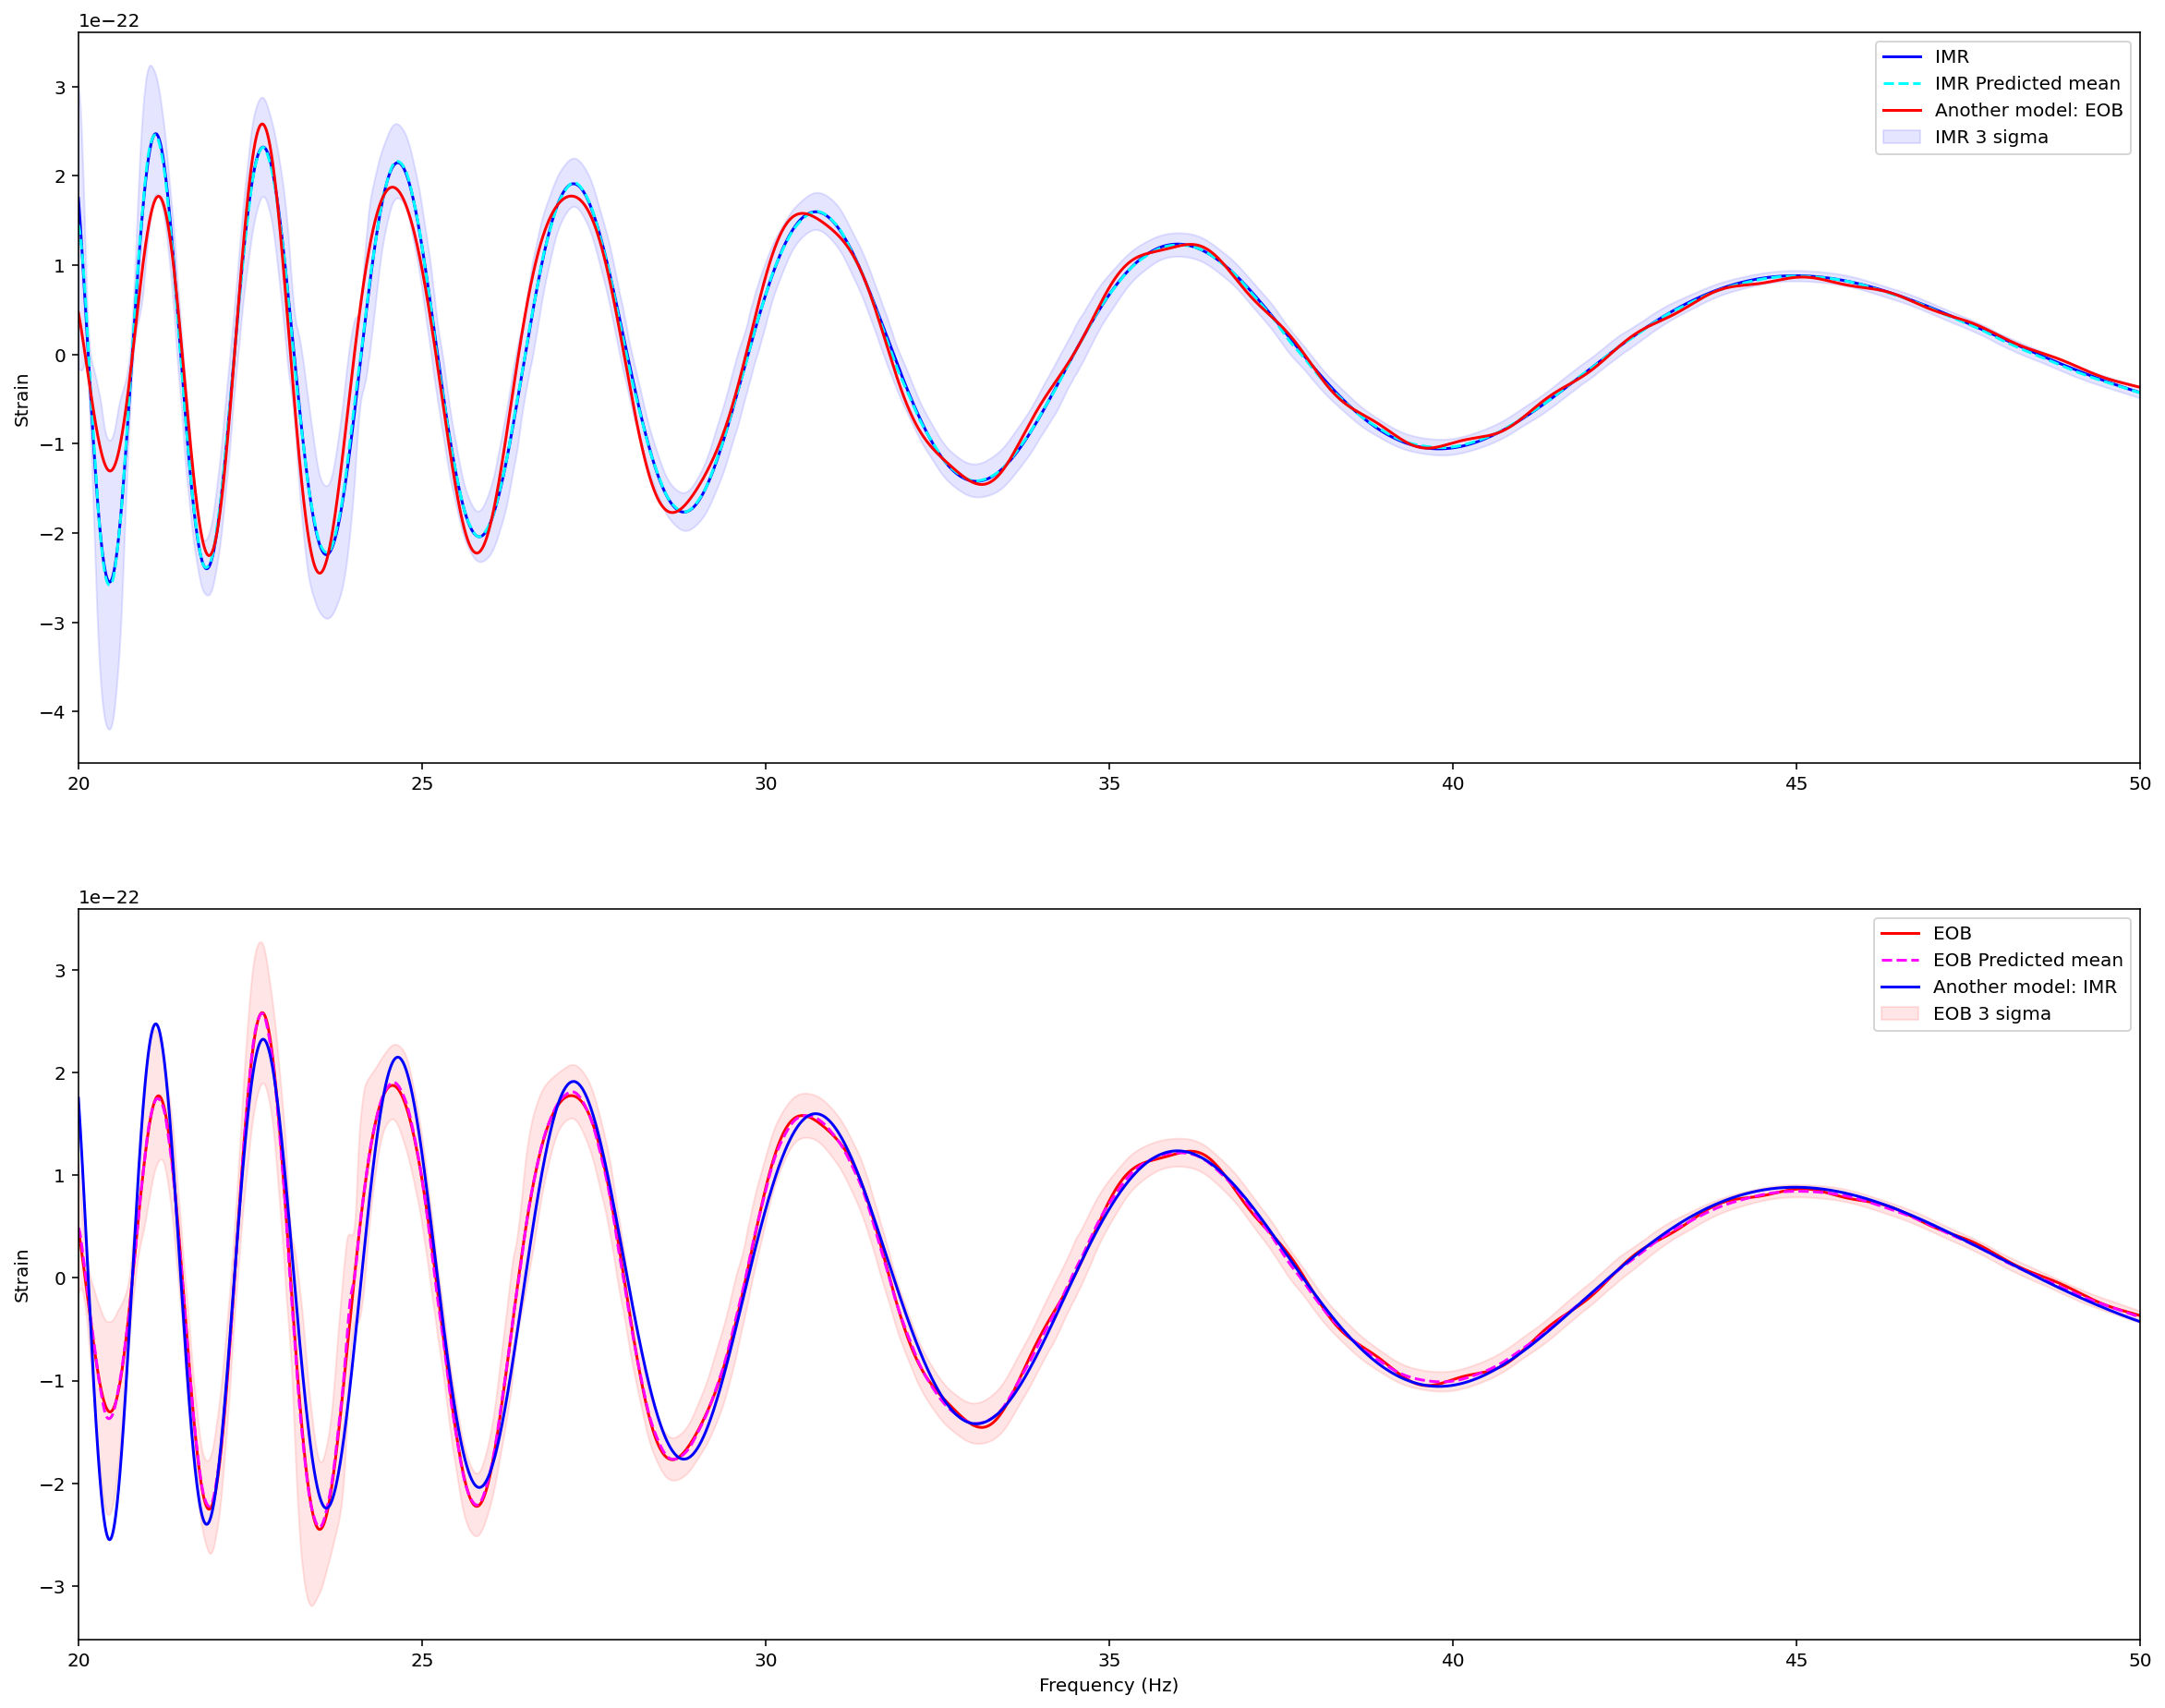

In [60]:
plt.figure(figsize=(20,16))
xlim_low=20
xlim_high=50
nsigma = 3

plt.subplot(2,1,1)
plt.plot(real_freq_test_imr, real_amp_test_imr, label='IMR', color='b')
plt.plot(real_freq_test_imr, real_mean_test_imr, label='IMR Predicted mean', color='cyan',linestyle='--')
plt.fill_between(x=real_freq_test_imr, y1=real_mean_test_imr-nsigma*real_std_test_imr, y2=real_mean_test_imr+nsigma*real_std_test_imr,
                 label=f'IMR {nsigma} sigma', alpha=0.1, color='b')
plt.plot(real_freq_test_eob, real_amp_test_eob, label='Another model: EOB', color='r',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.ylabel('Strain')



plt.subplot(2,1,2)
plt.plot(real_freq_test_eob, real_amp_test_eob, label='EOB', color='r')
plt.plot(real_freq_test_eob, real_mean_test_eob, label='EOB Predicted mean', color='magenta',linestyle='--')
plt.fill_between(x=real_freq_test_eob, y1=real_mean_test_eob-nsigma*real_std_test_eob, y2=real_mean_test_eob+nsigma*real_std_test_eob,
                 label=f'EOB {nsigma} sigma', alpha=0.1, color='r')
plt.plot(real_freq_test_imr, real_amp_test_imr, label='Another model: IMR', color='b',linestyle='-')
plt.legend()
plt.xlim(xlim_low,xlim_high)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Strain')
#plt.savefig('/home/qian.hu/neuron_process_waveform/test/trained_models/gp_reprod.png')
plt.show()